In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from model import FeatureDependentMarkovChain
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 150)

# https://chadwick.readthedocs.io/en/latest/cwevent.html

In [4]:
state_to_id = {}
id_to_state = {}
i = 0
for outs in [0, 1, 2]:
    for r3 in [0, 1]:
        for r2 in [0, 1]:
            for r1 in [0, 1]:
                state_to_id[(outs, r1, r2, r3)] = i
                id_to_state[i] = (outs, r1, r2, r3)
                i += 1
state_to_id["INNING OVER"] = i
id_to_state[i] = "INNING OVER"

def func(x):
    outs = x.OUTS_CT
    r1 = 0 if isinstance(x.BASE1_RUN_ID, float) else 1
    r2 = 0 if isinstance(x.BASE2_RUN_ID, float) else 1
    r3 = 0 if isinstance(x.BASE3_RUN_ID, float) else 1
    return state_to_id[(outs, r1, r2, r3)]

n = len(state_to_id)

In [5]:
headtohead = pd.read_csv("data/headtohead-2017.csv")
batters = headtohead.groupby("RESP_BAT_ID").sum()
batter_features = batters.iloc[:,2:] / batters.B_PA[:, None]
pitchers = headtohead.groupby("RESP_PIT_ID").sum()
pitcher_features = pitchers.iloc[:,2:] / pitchers.B_PA[:, None]

In [6]:
df = pd.read_csv("data/all2018.csv")
df = df[["GAME_ID", "GAME_NEW_FL", "GAME_END_FL", "EVENT_ID", "INN_CT", "BAT_HOME_ID", "OUTS_CT", "BASE1_RUN_ID", "BASE2_RUN_ID", "BASE3_RUN_ID", "AWAY_SCORE_CT", "HOME_SCORE_CT",
   "BAT_ID", "BAT_HAND_CD", "PIT_ID", "PIT_HAND_CD", "BAT_LINEUP_ID"]]
df = df.join(batter_features, on='BAT_ID').join(pitcher_features, on='PIT_ID', lsuffix='_PIT')
df["STATE"] = df.apply(func, axis=1)
df["BAT_PIT_SAME"] = df.BAT_HAND_CD == df.PIT_HAND_CD
df["SCORE_DIFF"] = (df["BAT_HOME_ID"] * 2 - 1) * (df.HOME_SCORE_CT - df.AWAY_SCORE_CT)
df["DATE"] = pd.to_datetime(df.GAME_ID.str[3:-1], format="%Y%m%d")
df["STADIUM"] = df.GAME_ID.str[:3]
df["DOUBLEHEADER"] = df.GAME_ID.str[-1]
df.sort_values(by=["DATE", "STADIUM", "DOUBLEHEADER", "EVENT_ID"], inplace=True)
df["Inning_over"] = (df[["INN_CT", "BAT_HOME_ID"]].shift(1) != df[["INN_CT", "BAT_HOME_ID"]]).any(axis=1)
df.iloc[0, -1] = False
df.head(5)

/home/shane/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (64,65,85) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,GAME_ID,GAME_NEW_FL,GAME_END_FL,EVENT_ID,INN_CT,BAT_HOME_ID,OUTS_CT,BASE1_RUN_ID,BASE2_RUN_ID,BASE3_RUN_ID,...,B_SH,B_SF,B_XI,STATE,BAT_PIT_SAME,SCORE_DIFF,DATE,STADIUM,DOUBLEHEADER,Inning_over
6267,ARI201803290,T,F,1,1,0,0,NaN,NaN,NaN,...,0.004843,0.006053,0.0,0,True,0,2018-03-29,ARI,0,False
6268,ARI201803290,F,F,2,1,0,1,NaN,NaN,NaN,...,0.004843,0.006053,0.0,8,False,0,2018-03-29,ARI,0,False
6269,ARI201803290,F,F,3,1,0,1,NaN,NaN,NaN,...,0.004843,0.006053,0.0,8,False,1,2018-03-29,ARI,0,False
6270,ARI201803290,F,F,4,1,0,1,arenn001,NaN,NaN,...,0.004843,0.006053,0.0,9,False,1,2018-03-29,ARI,0,False
6271,ARI201803290,F,F,5,1,0,2,arenn001,NaN,NaN,...,0.004843,0.006053,0.0,17,True,1,2018-03-29,ARI,0,False


In [7]:
features_df = df[['SCORE_DIFF', 'BAT_LINEUP_ID', 'BAT_HOME_ID', 'INN_CT', 'B_AB_PIT',
       'B_H_PIT', 'B_TB_PIT', 'B_2B_PIT', 'B_3B_PIT', 'B_HR_PIT', 'B_HR4_PIT',
       'B_RBI_PIT', 'B_BB_PIT', 'B_IBB_PIT', 'B_SO_PIT', 'B_GDP_PIT',
       'B_HP_PIT', 'B_SH_PIT', 'B_SF_PIT', 'B_XI_PIT', 'B_AB', 'B_H', 'B_TB',
       'B_2B', 'B_3B', 'B_HR', 'B_HR4', 'B_RBI', 'B_BB', 'B_IBB', 'B_SO',
       'B_GDP', 'B_HP', 'B_SH', 'B_SF', 'B_XI', 'BAT_HAND_CD', 'PIT_HAND_CD',
       'BAT_PIT_SAME']].copy()
features_df.INN_CT[features_df.INN_CT >= 10] = 10
features_df.SCORE_DIFF[features_df.SCORE_DIFF >= 3] = 3
features_df.SCORE_DIFF[features_df.SCORE_DIFF <= -3] = -3
dummy_cols = ["BAT_HAND_CD", "PIT_HAND_CD", "INN_CT", "BAT_LINEUP_ID", "SCORE_DIFF"]
for c in dummy_cols:
    features_df = pd.concat([features_df, pd.get_dummies(features_df[c], prefix=c)], axis=1)
features_df.drop(dummy_cols, axis=1, inplace=True)
features = features_df.values.astype(float)

/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load

In [8]:
# features_df = df[['BAT_LINEUP_ID']].copy()
# # features_df.INN_CT[features_df.INN_CT >= 10] = 10
# # features_df.SCORE_DIFF[features_df.SCORE_DIFF >= 3] = 3
# # features_df.SCORE_DIFF[features_df.SCORE_DIFF <= -3] = -3
# dummy_cols = ["BAT_LINEUP_ID"]
# for c in dummy_cols:
#     features_df = pd.concat([features_df, pd.get_dummies(features_df[c], prefix=c)], axis=1)
# features_df.drop(dummy_cols, axis=1, inplace=True)
# features = features_df.values

In [9]:
M = np.zeros((n, n))
R = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i == n-1:
            M[i, j] = 0 if j != n-1 else 1
        else:
            o_start, r1_start, r2_start, r3_start = id_to_state[i]
            if j == n-1:
                M[i, j] = 1 if o_start + r1_start + r2_start + r3_start + 1 >= 3 else 0
            else:
                o_end, r1_end, r2_end, r3_end = id_to_state[j]
                o = o_end - o_start
                r_start = r1_start + r2_start + r3_start
                r_end = r1_end + r2_end + r3_end
                runs = r_start - r_end + 1 - o
                runner_backwards = r3_start == 1 and r2_start == 0 and r1_start == 0 and r1_end == 1 and r2_end == 1
                M[i, j] = 1 if runs >= 0 and runs + o <= r_start + 1 and o >= 0 and not runner_backwards else 0
                R[i, j] = 0 if M[i, j] == 0 else runs
M.sum()

294.0

In [10]:
states = df["STATE"].values.copy()
lengths = np.diff(np.append(np.append(0, np.where(df["Inning_over"])[0]), df.shape[0])).copy()
i = 0
states_new = []
features_new = []
lengths_new = []
for l in lengths:
    if M[states[i:i+l][-1], 24] == 0: # game over early
        states_new += [states[i:i+l]]
        features_new += [features[i:i+l]]
        lengths_new += [l]
    else:
        states_new += [np.append(states[i:i+l], state_to_id["INNING OVER"])]
        features_new += [np.vstack([features[i:i+l], np.zeros((1, features.shape[1]))])]
        lengths_new += [l + 1]
    i += l
states = np.concatenate(states_new)
features = np.vstack(features_new)
lengths = np.array(lengths_new)

In [11]:
train_idx = int(lengths.size * .8)
val_idx = int(lengths.size * .9)

lengths_train = lengths[:train_idx]
lengths_val = lengths[train_idx:val_idx]
lengths_test = lengths[val_idx:]

states_train = states[:lengths_train.sum()]
states_val = states[lengths_train.sum():lengths_train.sum()+lengths_val.sum()]
states_test = states[lengths_train.sum()+lengths_val.sum():]

features_train = features[:lengths_train.sum()]
features_val = features[lengths_train.sum():lengths_train.sum()+lengths_val.sum()]
features_test = features[lengths_train.sum()+lengths_val.sum():]

# lengths_train = lengths_train[:5000]
# states_train = states_train[:sum(lengths_train)]
# features_train = features_train[:sum(lengths_train)]

# append some inning over sequences
states_train = np.append(states_train, [state_to_id["INNING OVER"]]*20)
lengths_train = np.append(lengths_train, 20)
features_train = np.vstack([features_train, np.zeros((20, features.shape[1]))])

In [12]:
features_train.shape, features_val.shape, features_test.shape

((187612, 64), (23482, 64), (23545, 64))

In [13]:
from sklearn.preprocessing import QuantileTransformer, StandardScaler
ss = StandardScaler()

features_train = ss.fit_transform(features_train)
features_val = ss.transform(features_val)
features_test = ss.transform(features_test)

/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


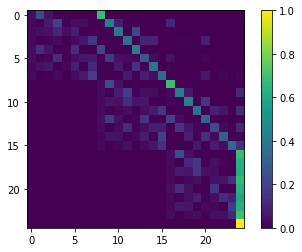

In [14]:
i = 0
P = np.zeros((25, 25))
for l in lengths:
    for j in range(i, i+l-1):
        if M[states[j], states[j+1]] == 0:
            print("ERROR")
            print (j, j+1)
        P[states[j], states[j+1]] += 1
    i += l
P = P / P.sum(axis=1)[:, None]
P[-1,:] = 0.
P[-1,-1] = 1.
plt.imshow(P, vmin=0, vmax=1)
plt.colorbar()
plt.savefig("figs/baseball_empirical.pdf")

In [191]:
(P > 0).sum(), M.sum()

(279, 294.0)

In [192]:
(P > 0).sum() / np.prod(P.shape)

0.4464

In [193]:
((P > 0) & ~(M > 0)).any()

False

In [194]:
M = P > 0

In [195]:
runs_list = []
atbats = []
for _ in range(1_000):
    state = 0
    runs = 0
    i = 1
    while True:
        outs, r1, r2, r3 = id_to_state[state]
        next_state = np.random.choice(np.arange(25), p=P[state])
        if id_to_state[next_state] == "INNING OVER":
            break
        runs += R[state, next_state]
        state = next_state
        i += 1
    atbats.append(i)
    runs_list.append(runs)

In [196]:
np.mean(atbats) * 9

39.519

0.617


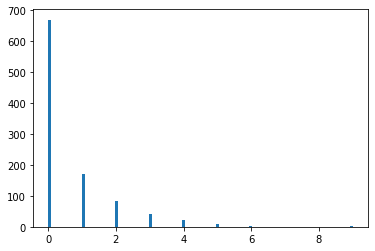

In [197]:
plt.hist(runs_list, bins=100);
print(np.mean(runs_list))

In [18]:
print("The second most probable transitions")
for i in range(25):
    print(id_to_state[i], id_to_state[np.argsort(P[i])[-2]], round(np.sort(P[i])[-2], 3))

The second most probable transitions
(0, 0, 0, 0) (0, 1, 0, 0) 0.231
(0, 1, 0, 0) (0, 1, 1, 0) 0.191
(0, 0, 1, 0) (1, 0, 0, 1) 0.226
(0, 1, 1, 0) (0, 1, 1, 1) 0.16
(0, 0, 0, 1) (1, 0, 0, 0) 0.207
(0, 1, 0, 1) (1, 1, 0, 0) 0.17
(0, 0, 1, 1) (1, 0, 0, 1) 0.148
(0, 1, 1, 1) (0, 1, 1, 1) 0.174
(1, 0, 0, 0) (1, 1, 0, 0) 0.231
(1, 1, 0, 0) (1, 1, 1, 0) 0.18
(1, 0, 1, 0) (2, 0, 0, 1) 0.163
(1, 1, 1, 0) (1, 1, 1, 1) 0.154
(1, 0, 0, 1) (2, 0, 0, 0) 0.199
(1, 1, 0, 1) (2, 1, 0, 0) 0.149
(1, 0, 1, 1) (1, 1, 1, 1) 0.191
(1, 1, 1, 1) (1, 1, 1, 1) 0.146
(2, 0, 0, 0) (2, 1, 0, 0) 0.237
(2, 1, 0, 0) (2, 1, 1, 0) 0.162
(2, 0, 1, 0) (2, 1, 1, 0) 0.156
(2, 1, 1, 0) (2, 1, 1, 1) 0.128
(2, 0, 0, 1) (2, 1, 0, 1) 0.155
(2, 1, 0, 1) (2, 0, 1, 1) 0.128
(2, 0, 1, 1) (2, 1, 1, 1) 0.183
(2, 1, 1, 1) (2, 1, 1, 1) 0.116
INNING OVER (1, 1, 1, 0) 0.0


In [23]:
model1 = FeatureDependentMarkovChain(n, lam_frob=0, mask=M, n_iter=1)
model1.fit(states_train, features_train*0, lengths_train, verbose=False)
model1.score(states_train, features_train*0, lengths_train, average=True), \
    model1.score(states_val, features_val*0, lengths_val, average=True), \
    model1.score(states_test, features_test*0, lengths_test, average=True)

(-1.1976343561279272, -1.1866588084490413, -1.2006951804959654)

In [24]:
from copy import deepcopy
for lam in np.logspace(-3,-1,10):
    model = FeatureDependentMarkovChain(n, lam_frob=lam, mask=M, n_iter=1)
    model.As = deepcopy(model1.As)
    model.bs = deepcopy(model1.bs)
    model.fit(states_train, features_train, lengths_train, verbose=False, warm_start=True)
    print(lam, model.score(states_train, features_train, lengths_train, average=True),
          model.score(states_val, features_val, lengths_val, average=True),
          model.score(states_test, features_test, lengths_test, average=True))

0.001 -1.1642633177289516 -1.1849057113474015 -1.1977115343894957
0.0016681005372000592 -1.1691931907624014 -1.1832865288434766 -1.1958556903042716
0.0027825594022071257 -1.17392743235028 -1.1823860399168205 -1.1947891081178117
0.004641588833612777 -1.1783221556813217 -1.1820831515105539 -1.1944287539755964
0.007742636826811269 -1.1822801240372212 -1.1822318845904587 -1.1946518937293842
0.01291549665014884 -1.1857530990685161 -1.1826893242482865 -1.1953104476434067
0.021544346900318832 -1.188712127011159 -1.1833190936467837 -1.1962245083523315
0.03593813663804626 -1.1911353281360142 -1.1839963918792016 -1.197202430569706
0.05994842503189409 -1.1930332107832735 -1.1846309228494094 -1.1980936729205027
0.1 -1.1944636708252965 -1.1851748402378577 -1.198830769671155


In [21]:
model = FeatureDependentMarkovChain(n, lam_frob=0.0046, mask=M, n_iter=1)
model.As = deepcopy(model1.As)
model.bs = deepcopy(model1.bs)
model.fit(states_train, features_train, lengths_train, verbose=False, warm_start=True)

In [22]:
for j in [0, 100, 200, 300]:
    print("\n\n", j)
    P = model.predict(features_train[j:j+1])[0]
    p = P[state_to_id[(0,1,0,0)]]
    for i in np.argsort(p)[-5:]:
        print(id_to_state[i], p[i])



 0
(1, 0, 1, 0) 0.06715597370542326
(0, 0, 1, 0) 0.07322190124142175
(2, 0, 0, 0) 0.09159807891538232
(0, 1, 1, 0) 0.20085851123640164
(1, 1, 0, 0) 0.439837810947215


 100
(1, 0, 1, 0) 0.0650768751065079
(0, 0, 1, 0) 0.06856649229141928
(2, 0, 0, 0) 0.08826108448274898
(0, 1, 1, 0) 0.1908800054676689
(1, 1, 0, 0) 0.4535987446284997


 200
(1, 0, 1, 0) 0.06749245034255441
(2, 0, 0, 0) 0.07460169375709395
(0, 0, 1, 0) 0.07974162449028278
(0, 1, 1, 0) 0.19079782789951802
(1, 1, 0, 0) 0.455662545049188


 300
(0, 0, 1, 0) 0.06135010407042618
(2, 0, 0, 0) 0.09283241776409795
(1, 0, 1, 0) 0.14992943243822315
(0, 1, 1, 0) 0.21263713415047475
(1, 1, 0, 0) 0.37496019945770775


In [203]:
starting_state = state_to_id[(0,0,0,0)]
ending_state = state_to_id[(0,0,0,1)]
j = np.where(model.nonzero[starting_state] == ending_state)[0][0]
A, b = model.As[starting_state], model.bs[starting_state]
print("most positive effect", features_df.columns[np.argsort(A[:,j])[-5:]])
print("most negative effect", features_df.columns[np.argsort(A[:,j])[:5]])

most positive effect Index(['B_SH', 'PIT_HAND_CD_R', 'BAT_LINEUP_ID_8', 'BAT_LINEUP_ID_5',
       'B_3B_PIT'],
      dtype='object')
most negative effect Index(['B_HR_PIT', 'B_GDP_PIT', 'B_XI', 'PIT_HAND_CD_L', 'BAT_LINEUP_ID_4'], dtype='object')


## With column norm regularization

In [76]:
model = FeatureDependentMarkovChain(n, lam_frob=0.0046, mask=M, n_iter=1, lam_col_norm=0.0035)
model.As = deepcopy(model1.As)
model.bs = deepcopy(model1.bs)
model.fit(states_train, features_train, lengths_train, verbose=False, warm_start=True)
print(model.score(states_train, features_train, lengths_train, average=True), \
    model.score(states_val, features_val, lengths_val, average=True), \
    model.score(states_test, features_test, lengths_test, average=True))
nnz = []
for i in range(model.As[0].shape[0]):
    col_norm = np.linalg.norm(np.concatenate([A[i,:] for A in model.As]))
    if col_norm > 0:
        nnz.append(i)
features_df.columns[nnz]

0 1.0 1.1976343561279268
1 1.2 1.19753054629369
2 1.44 1.197428331379743
3 1.728 1.1973295307539944
4 2.0736 1.1972356013848975
5 2.48832 1.1971475705462866
6 2.9859839999999997 1.1970660389923975
7 3.5831807999999996 1.1969913145965685
8 4.299816959999999 1.1969235884852918
9 5.159780351999999 1.196863132514955
10 6.191736422399999 1.1968102832382252
11 7.430083706879999 1.1967656944571194
12 8.916100448255998 1.196729851657655
13 10.699320537907196 1.1967023808585735
14 12.839184645488634 1.1966826879692143
15 15.407021574586361 1.1966696756477118
16 18.48842588950363 1.1966619167887433
17 22.186111067404358 1.1966577230138689
18 26.62333328088523 1.1966556816905265
19 31.947999937062274 1.1966547703736836
20 38.33759992447473 1.1966543592744605
21 46.005119909369675 1.1966543213261256
22 13.801535972810901 1.1966542466692336
23 8.28092158368654 1.196654089762686
24 9.937105900423848 1.1966540580963363
25 11.924527080508618 1.1966540336666902
26 14.309432496610341 1.196654009342402
2

Index(['B_HR_PIT', 'B_BB_PIT', 'B_SO_PIT', 'B_SH_PIT', 'B_3B', 'B_SO', 'B_GDP',
       'BAT_PIT_SAME', 'INN_CT_5', 'INN_CT_9', 'INN_CT_10', 'BAT_LINEUP_ID_1',
       'BAT_LINEUP_ID_3', 'BAT_LINEUP_ID_8', 'BAT_LINEUP_ID_9',
       'SCORE_DIFF_-3'],
      dtype='object')